# Physics-Informed Neural Networks (PINNs)

Can we leverage data-science to solve systems of differential equations?
The answer is obviously yes!

Let's start from the canonical definition of an ANN.

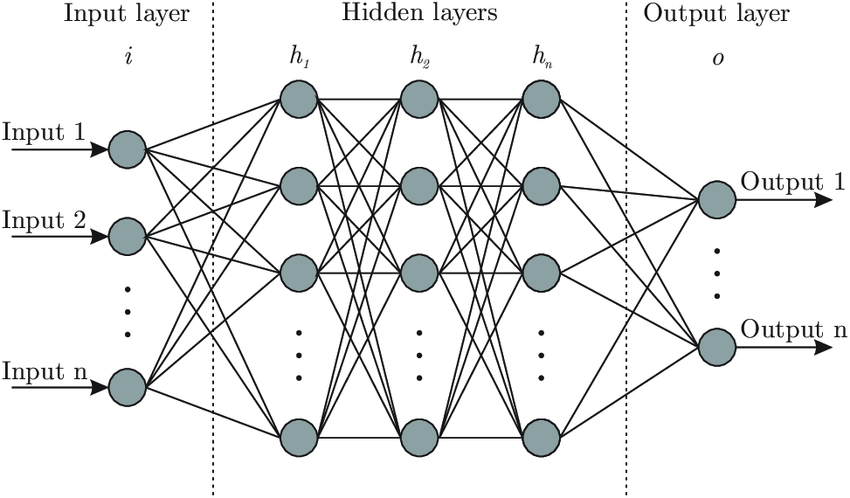

The ANN is composed of a set of affine transformations followed by non-linearities (in the activation function(s)).

**Inputs** = $X$

**Outputs** = $Y$

**Parameters**: $\theta$

**Function**: $y=N(x;\theta)$

Training is performed in many different ways, depending on the goal. For supervised regression learning problems, we can use **stochastic gradient descent**:

**Loss Function**: 

$L(\theta) = \frac{1}{n} \sum_{i=1}^n \left[ y_i-N(x_i;\theta)\right]^2$

To minimize $L(\theta)$, we need to compute the derivative of the loss function with respect to the training parameters $\theta$, and "move" in the direction opposite to the gradient (i.e., we are minimizing the loss):

$\theta_{t+1} = \theta_t - \lambda_t \frac{1}{m}\sum_{j=1}^m \nabla_\theta \left[ y_{i_j} - N(x_{i_j},\theta_t)\right]^2$

The gradients $\nabla_\theta$ are generally computed with **automatic differentiation**.

# Ordinary Differential Equation

Let's apply these to the following initial value problem:

$\frac{d\Psi}{dx}=f(x,\Psi)$

$\Psi(0)=A$

**Important**! The following parametrization automatically satisfies the initial condition:

$\hat{\Psi}(x;\theta)=A+xN(x;\theta)$

The idea is to minimize the *integrated squared residual* of the ODE:

$L(\theta)=\int_0^1\left[\frac{d\hat{\Psi}(x;\theta)}{dx}-f(x,\hat{\Psi}(x;\theta)) \right]^2 dx$


**Super Important**! We will pick locations (i.e., $x_i$ values) randomly from a uniform distribution (this ensures convergence).

In [31]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
from gplearn.genetic import SymbolicRegressor
from sklearn.utils.random import check_random_state
from time import perf_counter
from PIL import Image
from functools import partial

device = torch.device("cpu")

From *Lagaris et al., 1997*:

$\frac{d\Psi}{dx} + \frac{\Psi}{5} =e^{-\frac{x}{5}} cos(x)$

In [28]:
N = nn.Sequential(nn.Linear(1,50), nn.Sigmoid(), nn.Linear(50, 1, bias=False))

A = 0.

Psi_t = lambda x: A + x * N(x)  # Function Definition
f = lambda x, Psi: torch.exp(-x/5.0) * torch.cos(x) - Psi / 5.0

# Loss Function
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs = torch.ones_like(outputs), create_graph = True)[0]
    return torch.mean((Psi_t_x - f(x, outputs))**2)

First, let's try gradient descent:

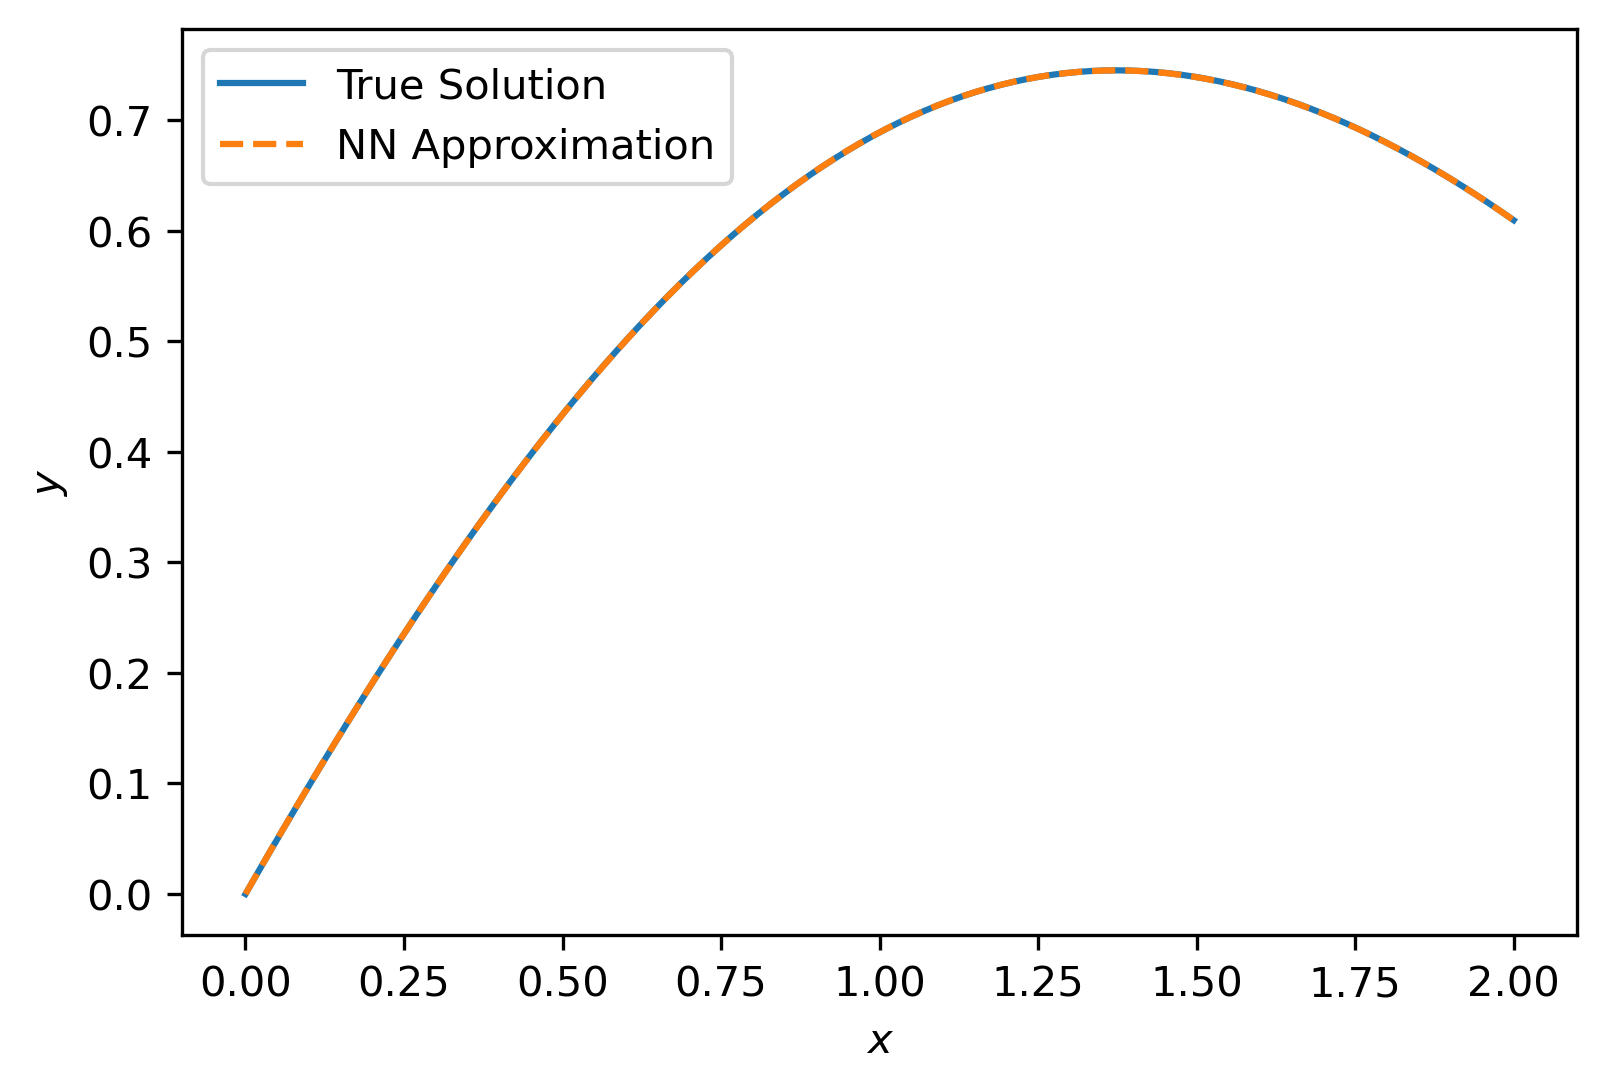

In [29]:
optimizer = torch.optim.LBFGS(N.parameters())

x = torch.Tensor(np.linspace(0,2,100)[:, None])

def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l

for i in range(10):
    optimizer.step(closure)
    
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi = 300)
ax.plot(xx, yt, label='True Solution')
ax.plot(xx, yy, '--', label='NN Approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best')

In [39]:
est_gp = SymbolicRegressor(population_size=500,
                           generations=500, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
rng = check_random_state(0)

X_train = rng.uniform(0, 2, 100).reshape(100, 1)
with torch.no_grad():
    y_train = Psi_t(torch.Tensor(xx)).numpy()

est_gp.fit(X_train, y_train.reshape(100, ))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.66          168.791        7         0.161378         0.165086      4.02m
   1    11.43           1.3248        7         0.160032         0.177204      2.31m
   2     7.50          13.1134        3          0.14483         0.314018      2.08m
   3     3.51         0.647297        3          0.14441         0.317795      1.93m
   4     2.02           0.3839        3         0.140161         0.356041      1.88m
   5     1.66         0.299009        1         0.144275         0.344857      1.97m
   6     1.34         0.315811        1         0.139094         0.391487      1.90m
   7     1.46         0.935759        1         0.143507         0.351766      1.87m
   8     1.54          1.78571        1         0.142654         0.328276  

  94     1.61         0.334652        1          0.13601          0.38808      1.59m
  95     1.52         0.295968        1         0.139493         0.356726      1.59m
  96     1.49          0.33532        1         0.140667         0.346166      1.58m
  97     1.79         0.735634        1          0.14323         0.323094      1.56m
  98     1.60         0.829668        1         0.139638         0.355428      1.57m
  99     1.57         0.335631        1         0.138406         0.366512      1.53m
 100     1.80         0.282981        1         0.139711         0.354765      1.53m
 101     1.68         0.402764        1         0.137952         0.347503      1.47m
 102     1.40         0.293693        1         0.145921          0.29888      1.57m
 103     1.96         0.534477        1         0.137807         0.371901      1.58m
 104     1.57         0.426748        1         0.140593         0.346831      1.50m
 105     1.80          1.16243        1         0.139161         

 191     1.64         0.681959        1         0.142198         0.309289      1.29m
 192     1.76          2.06466        1         0.140082          0.32833      1.47m
 193     1.65          4.26528        1         0.141274          0.31761      1.29m
 194     1.64         0.708663        1         0.139238         0.335929      1.32m
 195     1.47         0.557123        1         0.137214         0.354144      1.42m
 196     1.60          14.5131        1         0.138646         0.341262      1.24m
 197     2.01          1.61534        1          0.14113         0.318898      1.26m
 198     1.48         0.418891        1         0.139098         0.337186      1.29m
 199     1.55         0.695245        1         0.136789          0.35797      1.34m
 200     1.53         0.883198        1         0.142497         0.306595      1.31m
 201     1.17         0.215554        1         0.140719         0.322598      1.30m
 202     1.77         0.721099        1         0.140249         

 288     1.34         0.396277        1         0.139157         0.336661     57.02s
 289     1.67         0.422678        1         0.141839         0.312525     56.26s
 290     1.62         0.280655        1         0.139702         0.331753     55.88s
 291     1.44         0.589247        1         0.141885          0.31211      1.01m
 292     1.70         0.344991        1          0.14179          0.31296      1.03m
 293     1.37         0.272234        1         0.141285         0.317509     58.58s
 294     1.29          6.67748        1         0.140508         0.324496     50.99s
 295     1.80         0.459464        1         0.140575         0.323897     55.53s
 296     1.62         0.449295        1         0.139794         0.330924     53.52s
 297     1.56         0.373964        1         0.138644         0.341277     52.83s
 298     1.64         0.342854        1          0.14028         0.326555     52.39s
 299     1.80          0.34002        1         0.137558         

 385     1.53         0.320047        1         0.141927         0.311731     30.53s
 386     1.58         0.359683        1         0.137513         0.351458     30.50s
 387     1.55         0.368252        1         0.137961         0.347426     30.01s
 388     1.56         0.338375        1         0.140002         0.329051     30.08s
 389     1.80         0.609844        1         0.135428         0.370221     30.18s
 390     1.57          2.86054        1         0.138527         0.342331     29.34s
 391     1.82         0.458887        1         0.140484         0.324718     29.10s
 392     1.46         0.364884        1         0.138352           0.3439     28.41s
 393     1.48         0.291193        1         0.142203         0.309248     27.99s
 394     1.66          3.03123        1         0.141758          0.31325     28.40s
 395     1.42          1.43014        1         0.140792          0.32194     27.66s
 396     1.28          0.22904        1         0.139762         

 482     1.46         0.333775        1         0.133459         0.387941      4.74s
 483     1.62         0.248955        1         0.143363         0.298801      4.54s
 484     2.07          26.2374        1         0.135149          0.37273      4.26s
 485     1.88          1.15223        1         0.139927         0.329726      3.96s
 486     1.85         0.362289        1         0.134502         0.378552      3.68s
 487     1.63         0.736328        1         0.137427         0.352233      3.32s
 488     1.53         0.528174        1         0.135483         0.369723      3.07s
 489     1.42         0.236296        1         0.132941           0.3926      2.77s
 490     1.49         0.273892        1         0.138848         0.339439      2.58s
 491     1.75          3.68838        1         0.139682         0.331933      2.26s
 492     1.51         0.292489        1         0.142896         0.303006      1.98s
 493     1.69         0.389173        1         0.137638         

SymbolicRegressor(generations=500, max_samples=0.9, p_crossover=0.7,
                  p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=500, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [45]:
est_gp.set_params(generations=200, warm_start=True)
est_gp.fit(X_train, y_train)

/Users/fascetti/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: generations=200 must be larger or equal to len(_programs)=500 when warm_start==True

# Stochastic Gradient Descent

In [ ]:
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

adam = torch.optim.Adam(N.parameters(), lr = 0.01)

n_batch = 15 # Stochastic points sampled per iteration

max_it = 1000

for i in range(max_it):
    x = 2 * torch.rand(n_batch, 1)  # Domain is from 0 to 2
    adam.zero_grad()
    l = loss(x)
    l.backward()
    adam.step()
    if i % 100 == 99:
        print(i+1)
        
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi = 300)
ax.plot(xx, yt, label='True Solution')
ax.plot(xx, yy, '--', label='NN Approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best')

# Solving an Elliptic PDE

Let's apply this to a more interesting case! Start with a standard elliptic PDE:

$-\nabla \cdot [a(x)\nabla u(x)] + c(x)u(x) = f(x) $

Very similar to the previous example, we can define the loss function:

$L(\theta) = \int \left\{\nabla \cdot [a(x)\nabla \hat{u}(x;\theta)] + c(x)\hat{u}(x;\theta)+f(x) \right\}^2dx$

However, in this case, it is more convenient to invoke the Dirichlet principle: solving the PDE is equivalent to minimizing the energy associated with the field $u$.


$L(\theta) = \int \left\{\frac{1}{2}a(x)\nabla \hat{u}(x;\theta) + c(x)\hat{u}^2(x;\theta)-f(x)\hat{u}(x;\theta) \right\}^2dx - \int_{\Gamma_N}g_N\hat{u}(x;\theta)d\Gamma_N$

**NB**: $\Gamma_N$ is the natural boundary condition domain!

# Thermal Conductivity Example

$-\nabla \cdot [a(x; \xi)\nabla u(x;\xi)] + c(x)u(x;\xi) = f(x) $

**NB**: $\xi$ is a set of parameters that we use to *parametrize* the ODE! The important thing here is that the data-based approach is capable of solving all the parametrizations in a single training cycle!

$u = 0, \forall x_1 = 1$,

$u = 1, \forall x_1 = 0$,

$\frac{\partial u}{\partial n} = 0, \forall x_2 = 1$.

